# Regressão XGBoost

### 1. Configuração Inicial

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Configurações de exibição
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
%matplotlib inline

### 2. Carregamento dos Dados

In [2]:
print("Carregando os dados...")
data_dir = Path('../data/raw')
train_path = data_dir / 'train.csv'
test_path = data_dir / 'test.csv'

try:
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    print(f"Dados de treino carregados: {train_df.shape}")
    print(f"Dados de teste carregados: {test_df.shape}")
except Exception as e:
    print(f"Erro ao carregar os dados: {e}")
    raise

Carregando os dados...
Dados de treino carregados: (1460, 81)
Dados de teste carregados: (1459, 80)


### 3. Análise Exploratória de Dados (EDA)

In [3]:
print("\nAnálise Exploratória de Dados...")

# Visualização das primeiras linhas
print("\nVisualizando as primeiras linhas do conjunto de treino:")
display(train_df.head())

# Estatísticas descritivas
print("\nEstatísticas descritivas das variáveis numéricas:")
display(train_df.describe())

# Verificando valores ausentes
print("\nValores ausentes por coluna (treino):")
missing_train = train_df.isnull().sum().sort_values(ascending=False)
missing_train = missing_train[missing_train > 0]
display(missing_train)


Análise Exploratória de Dados...

Visualizando as primeiras linhas do conjunto de treino:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000



Estatísticas descritivas das variáveis numéricas:


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000



Valores ausentes por coluna (treino):


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

### 4. Pré-processamento dos Dados

In [4]:
print("\nPré-processando os dados...")

# Separando features e target
X = train_df.drop(['Id', 'SalePrice'], axis=1)
y = train_df['SalePrice']
X_test_sub = test_df.drop('Id', axis=1)

# Identificando colunas numéricas e categóricas
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Definindo transformações
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Para XGBoost, usamos LabelEncoder em vez de OneHot para evitar alta dimensionalidade
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combinando transformações
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Aplicando transformações
print("Aplicando transformações...")
X_processed = preprocessor.fit_transform(X)
X_test_processed = preprocessor.transform(X_test_sub)

# Obtendo os nomes das features após o pré-processamento
numeric_features = list(numeric_cols)
categorical_features = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols).tolist()
feature_names = numeric_features + categorical_features

# Convertendo para DMatrix (formato otimizado para XGBoost)
dtrain = xgb.DMatrix(X_processed, label=y, feature_names=feature_names)

# Dividindo em conjuntos de treino e validação
X_train, X_val, y_train, y_val = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

# Criando DMatrix para treino e validação
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=feature_names)

print(f"\nShape dos dados processados:")
print(f"- Treino: {X_train.shape}")
print(f"- Validação: {X_val.shape}")
print(f"- Teste: {X_test_processed.shape}")


Pré-processando os dados...
Aplicando transformações...

Shape dos dados processados:
- Treino: (1168, 287)
- Validação: (292, 287)
- Teste: (1459, 287)


### 5. Treinamento do Modelo XGBoost


Treinando o modelo XGBoost...
Treinando com early stopping...
[0]	train-rmse:70859.28553	val-rmse:81144.26110
[100]	train-rmse:5870.89644	val-rmse:25970.51284
[200]	train-rmse:2280.33822	val-rmse:25830.36697
[248]	train-rmse:1526.10666	val-rmse:25851.51218

Avaliação do Modelo Inicial:

Métricas para Treino:
  - RMSE: 1526.11
  - R²: 0.9996
  - MAE: 1134.78

Métricas para Validação:
  - RMSE: 25851.51
  - R²: 0.9129
  - MAE: 16570.44


<Figure size 1200x800 with 0 Axes>

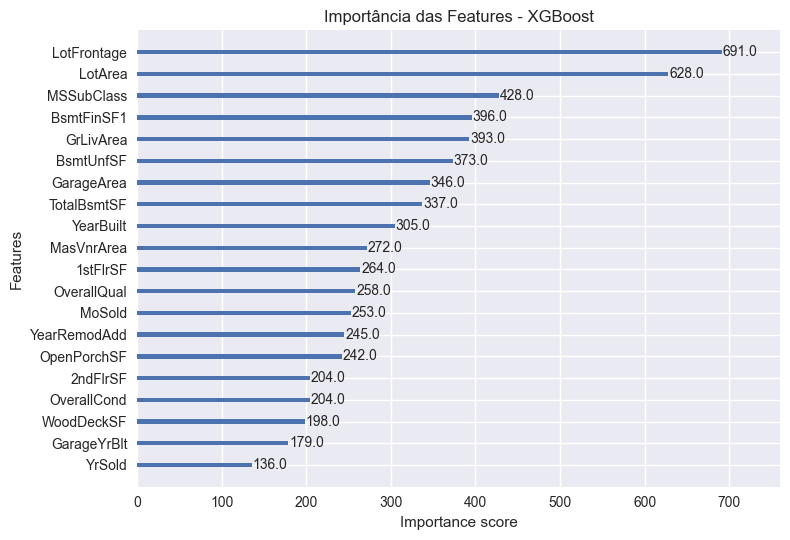

In [5]:
print("\nTreinando o modelo XGBoost...")

# Parâmetros iniciais
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Número de árvores
num_boost_round = 1000
early_stopping_rounds = 50

# Treinamento com early stopping
print("Treinando com early stopping...")
evals_result = {}
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=early_stopping_rounds,
    evals_result=evals_result,
    verbose_eval=100
)

# Função para avaliação do modelo
def evaluate_model(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    
    print(f"\nMétricas para {dataset_name}:")
    print(f"  - RMSE: {rmse:.2f}")
    print(f"  - R²: {r2:.4f}")
    print(f"  - MAE: {mae:.2f}")
    
    return rmse, r2, mae

# Fazendo previsões
y_train_pred = model.predict(dtrain)
y_val_pred = model.predict(dval)

# Avaliando o modelo
print("\nAvaliação do Modelo Inicial:")
train_metrics = evaluate_model(y_train, y_train_pred, "Treino")
val_metrics = evaluate_model(y_val, y_val_pred, "Validação")

# Plotando a importância das features
plt.figure(figsize=(12, 8))
xgb.plot_importance(model, max_num_features=20)
plt.title('Importância das Features - XGBoost')
plt.tight_layout()
plt.savefig('../outputs/figures/feature_importance_xgboost.png')
plt.show()

### 6. Otimização de Hiperparâmetros

In [6]:
print("\nOtimizando hiperparâmetros...")

# Definindo a grade de parâmetros para busca
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Usando a API do scikit-learn para XGBoost para facilitar o GridSearchCV
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42,
    n_jobs=-1
)

# Usando RandomizedSearchCV para economizar tempo
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,  # Número de iterações aleatórias
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Executando a busca
print("Iniciando busca aleatória...")
random_search.fit(X_train, y_train)

# Melhores parâmetros
print("\nMelhores parâmetros encontrados:")
print(random_search.best_params_)

# Melhor modelo
best_xgb = random_search.best_estimator_

# Avaliando o modelo otimizado
print("\nAvaliação do Modelo Otimizado:")
y_train_pred_opt = best_xgb.predict(X_train)
y_val_pred_opt = best_xgb.predict(X_val)

train_metrics_opt = evaluate_model(y_train, y_train_pred_opt, "Treino (Otimizado)")
val_metrics_opt = evaluate_model(y_val, y_val_pred_opt, "Validação (Otimizado)")



Otimizando hiperparâmetros...
Iniciando busca aleatória...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Melhores parâmetros encontrados:
{'subsample': 0.6, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}

Avaliação do Modelo Otimizado:

Métricas para Treino (Otimizado):
  - RMSE: 9223.72
  - R²: 0.9857
  - MAE: 6969.95

Métricas para Validação (Otimizado):
  - RMSE: 26097.00
  - R²: 0.9112
  - MAE: 15561.17


### 7. Treinamento Final com os Melhores Parâmetros

In [7]:
print("\nTreinando o modelo final com todos os dados de treino...")

# Usando os melhores parâmetros encontrados
final_params = random_search.best_params_
final_params.update({
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': 42,
    'n_jobs': -1
})

# Criando DMatrix final com todos os dados
dfull = xgb.DMatrix(X_processed, label=y, feature_names=feature_names)

# Treinando o modelo final
final_model = xgb.train(
    final_params,
    dfull,
    num_boost_round=1000,  # Pode ajustar com base no early stopping
    verbose_eval=100
)


Treinando o modelo final com todos os dados de treino...


### 8. Fazendo Previsões no Conjunto de Teste

In [8]:
print("\nFazendo previsões no conjunto de teste...")

# Criando DMatrix para o conjunto de teste
dtest = xgb.DMatrix(X_test_processed, feature_names=feature_names)

# Fazendo previsões
test_predictions = final_model.predict(dtest)

# Criando o arquivo de submissão
submission = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': test_predictions
})


Fazendo previsões no conjunto de teste...


In [9]:
# Salvando o arquivo de submissão
os.makedirs('../outputs', exist_ok=True)
submission_path = '../outputs/submission_xgboost.csv'
submission.to_csv(submission_path, index=False)
print(f"\nArquivo de submissão salvo em: {submission_path}")


Arquivo de submissão salvo em: ../outputs/submission_xgboost.csv


In [10]:
# Visualizando as primeiras linhas da submissão
print("\nVisualização das primeiras previsões:")
display(submission.head())


Visualização das primeiras previsões:


,Id,SalePrice
0,1461,133511.015625
1,1462,161772.453125
2,1463,192935.515625
3,1464,189276.328125
4,1465,181557.000000


### 9. Análise de Overfitting e Underfitting


Analisando overfitting/underfitting...
Avaliando com 50 árvores...
Avaliando com 100 árvores...
Avaliando com 200 árvores...
Avaliando com 300 árvores...
Avaliando com 400 árvores...
Avaliando com 500 árvores...


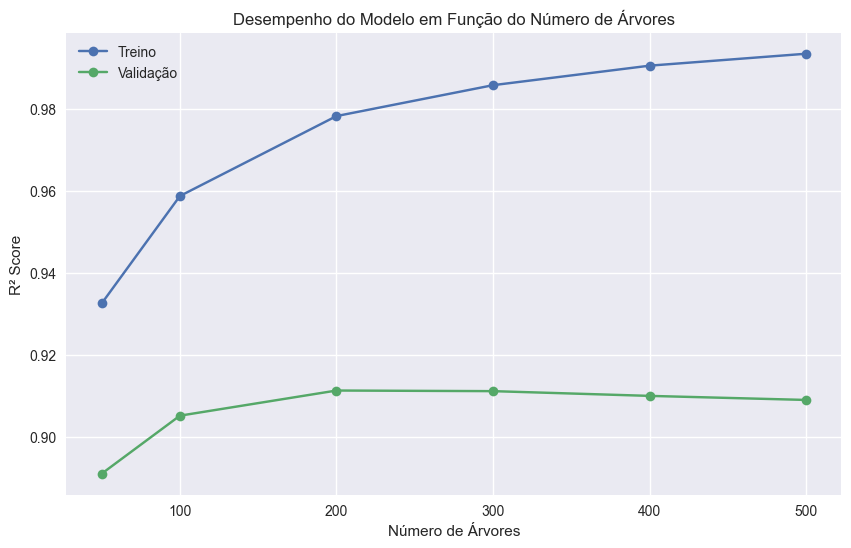

In [11]:
print("\nAnalisando overfitting/underfitting...")

# Avaliando o desempenho em diferentes números de árvores
n_estimators = [50, 100, 200, 300, 400, 500]
train_scores = []
val_scores = []

for n in n_estimators:
    print(f"Avaliando com {n} árvores...")
    model = xgb.XGBRegressor(
        n_estimators=n,
        **{k: v for k, v in final_params.items() if k not in ['n_estimators']}
    )
    model.fit(X_train, y_train)
    train_scores.append(r2_score(y_train, model.predict(X_train)))
    val_scores.append(r2_score(y_val, model.predict(X_val)))

# Plotando os resultados
plt.figure(figsize=(10, 6))
plt.plot(n_estimators, train_scores, label='Treino', marker='o')
plt.plot(n_estimators, val_scores, label='Validação', marker='o')
plt.xlabel('Número de Árvores')
plt.ylabel('R² Score')
plt.title('Desempenho do Modelo em Função do Número de Árvores')
plt.legend()
plt.grid(True)
plt.savefig('../outputs/figures/n_estimators_analysis_xgboost.png')
plt.show()

### 10. Salvando o Modelo

In [12]:
print("\nSalvando o modelo...")
import joblib

# Criando diretório de modelos se não existir
os.makedirs('../outputs/models', exist_ok=True)

# Salvando o modelo
model_path = '../outputs/models/xgboost_model.json'
final_model.save_model(model_path)
print(f"Modelo salvo em: {model_path}")

# Salvando o pré-processador
preprocessor_path = '../outputs/models/xgboost_preprocessor.joblib'
joblib.dump(preprocessor, preprocessor_path)
print(f"Pré-processador salvo em: {preprocessor_path}")



Salvando o modelo...
Modelo salvo em: ../outputs/models/xgboost_model.json
Pré-processador salvo em: ../outputs/models/xgboost_preprocessor.joblib
